In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from typing import Dict, List

# Set TensorFlow logging level to suppress unnecessary output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Helper function: Load embeddings from TFRecord files
def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        embedding_feature = example.features.feature['embedding']
        embedding_values = embedding_feature.float_list.value
    embedding = torch.tensor(embedding_values)
    if torch.isnan(embedding).any() or torch.isinf(embedding).any():
        raise ValueError(f"NaN or Inf found in embedding: {embedding_path}")
    return embedding

# Custom dataset class for MIMIC chest X-ray embeddings
class MIMIC_Embed_Dataset(Dataset):
    pathologies = [
        "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
        "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
        "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
    ]

    def __init__(self, embedpath, csvpath, metacsvpath, views=["PA"], mode="train", seed=42, split_ratio=[0.5, 0.3, 0.2], unique_patients=True):
        super().__init__()
        np.random.seed(seed)  # Set seed for reproducibility
        self.pathologies = sorted(self.pathologies)
        self.mode = mode
        self.embedpath = embedpath
        self.csv = pd.read_csv(csvpath)
        self.metacsv = pd.read_csv(metacsvpath)
        self.split_ratio = split_ratio

        # Merge CSV data
        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.csv = self.csv.join(self.metacsv).reset_index()

        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        # Split dataset into train, validation, and test sets
        n_row = self.csv.shape[0]
        if self.mode == "train":
            self.csv = self.csv[:int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[int(n_row * self.split_ratio[0]):int(n_row * (self.split_ratio[0] + self.split_ratio[1]))]
        elif self.mode == "test":
            self.csv = self.csv[int(n_row * (self.split_ratio[0] + self.split_ratio[1])):]
        else:
            raise ValueError(f"mode must be one of [train, valid, test], got {self.mode}")

        # Process labels
        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
            labels.append(mask.values)
        self.labels = np.asarray(labels).T.astype(np.float32)
        self.labels[np.isnan(self.labels)] = 0  # Replace all NaN values with 0
        self.labels = np.where((self.labels != 0) & (self.labels != 1), 0, self.labels)

        self.csv = self.csv.reset_index(drop=True)
        self.pathologies = list(np.char.replace(self.pathologies, "Pleural Effusion", "Effusion"))
        self.csv["offset_day_int"] = self.csv["StudyDate"]
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def limit_to_selected_views(self, views):
        # Limit dataset to specified views
        if not isinstance(views, list):
            views = [views]
        if '*' in views:
            views = ["*"]
        self.views = views
        self.csv["view"] = self.csv["view"].fillna("UNKNOWN")
        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve a single sample from the dataset
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]
        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])
        embed_file = os.path.join(self.embedpath, f"p{subjectid[:2]}", f"p{subjectid}", f"s{studyid}", f"{dicom_id}.tfrecord")
        sample["embedding"] = load_embedding(embed_file)
        return sample

# Function to initialize datasets with given paths, seed, and split ratio
def initialize_mimic_datasets(embedpath, csvpath, metacsvpath, seed=42, split_ratio=[0.5, 0.3, 0.2]):
    """
    Initialize MIMIC chest X-ray datasets with specified paths, seed, and split ratio.
    
    Args:
        embedpath (str): Path to the embedding files
        csvpath (str): Path to the CheXpert CSV file
        metacsvpath (str): Path to the metadata CSV file
        seed (int): Random seed for reproducibility (default: 42)
        split_ratio (list): Train, validation, test split ratio (default: [0.5, 0.3, 0.2])
    
    Returns:
        tuple: (train_dataset, val_dataset, test_dataset)
    """
    train_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="train",
        seed=seed,
        split_ratio=split_ratio
    )
    val_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="valid",
        seed=seed,
        split_ratio=split_ratio
    )
    test_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="test",
        seed=seed,
        split_ratio=split_ratio
    )
    return train_dataset, val_dataset, test_dataset

In [2]:
def collate_fn(batch):
    embeddings = torch.stack([item['embedding'] for item in batch])
    labels = torch.stack([torch.tensor(item['lab']) for item in batch])
    return {"embedding": embeddings, "lab": labels}

In [3]:
embedpath = "/kaggle/input/generalized-image-embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
csvpath = "/kaggle/input/mimic-cxr-2-0-0-chexpert/mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "/kaggle/input/mimic-cxr-2-0-0-metadata/mimic-cxr-2.0.0-metadata.csv"

train_dataset, valid_dataset, test_dataset = initialize_mimic_datasets(
    embedpath=embedpath,
    csvpath=csvpath,
    metacsvpath=metacsvpath,
    seed=42,
    split_ratio=[0.5, 0.3, 0.2]
)


train_dataset.labels[np.isnan(train_dataset.labels)] = 0
valid_dataset.labels[np.isnan(valid_dataset.labels)] = 0
test_dataset.labels[np.isnan(test_dataset.labels)] = 0

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [4]:
sample = next(iter(train_loader))

print(sample['embedding'].shape)

torch.Size([32, 1376])


In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)  # pt就是预测正确的概率
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [6]:
class SimpleTransformerClassifier(nn.Module):
    def __init__(self, input_dim=1376, num_classes=13, hidden_dim=512, nhead=8, num_layers=2, dropout=0.3, seq_len=8):
        super(SimpleTransformerClassifier, self).__init__()
        
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        assert input_dim % seq_len == 0, "input_dim必须能被seq_len整除"
        
        self.input_proj = nn.Linear(input_dim // seq_len, hidden_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim*2,
            activation='gelu',
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Attention Pooling
        self.attention_pool = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)  # 输出一个attention score
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = x.view(batch_size, self.seq_len, -1)  # (batch_size, seq_len, input_dim//seq_len)
        x = self.input_proj(x)                    # (batch_size, seq_len, hidden_dim)
        x = self.transformer_encoder(x)           # (batch_size, seq_len, hidden_dim)
        
        # Attention Pooling
        attn_scores = self.attention_pool(x).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch_size, seq_len)
        attn_weights = attn_weights.unsqueeze(-1)         # (batch_size, seq_len, 1)
        
        x = (x * attn_weights).sum(dim=1)  # (batch_size, hidden_dim)，加权和
        
        out = self.classifier(x)
        return out  # logits

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleTransformerClassifier(
    input_dim=1376,
    num_classes=13,
    hidden_dim=512,
    nhead=8,
    num_layers=2,
    dropout=0.3,
    seq_len=8  # 注意要加上
).to(device)

criterion = FocalLoss(alpha=0.75, gamma=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 训练过程
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch in train_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['lab'].to(device)
            
            optimizer.zero_grad()
            outputs = model(embeddings)  # (batch_size, 13)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer)

torch.save(model.state_dict(), 'transformer_model.pth')

Epoch [1/20], Loss: 0.0320
Epoch [2/20], Loss: 0.0284
Epoch [3/20], Loss: 0.0279
Epoch [4/20], Loss: 0.0275
Epoch [5/20], Loss: 0.0273
Epoch [6/20], Loss: 0.0269
Epoch [7/20], Loss: 0.0267
Epoch [8/20], Loss: 0.0265
Epoch [9/20], Loss: 0.0261
Epoch [10/20], Loss: 0.0261
Epoch [11/20], Loss: 0.0256
Epoch [12/20], Loss: 0.0253
Epoch [13/20], Loss: 0.0249
Epoch [14/20], Loss: 0.0245
Epoch [15/20], Loss: 0.0240
Epoch [16/20], Loss: 0.0235
Epoch [17/20], Loss: 0.0229
Epoch [18/20], Loss: 0.0222
Epoch [19/20], Loss: 0.0216
Epoch [20/20], Loss: 0.0208



F1 Score (macro): 0.2811

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.45      0.43       855
     Class 1       0.36      0.60      0.45       761
     Class 2       0.15      0.13      0.14       166
     Class 3       0.33      0.42      0.37       229
     Class 4       0.06      0.01      0.02       139
     Class 5       0.14      0.02      0.04       184
     Class 6       0.23      0.19      0.21       271
     Class 7       0.34      0.52      0.41      1120
     Class 8       0.49      0.72      0.59       742
     Class 9       0.11      0.10      0.11        81
    Class 10       0.26      0.30      0.28       431
    Class 11       0.29      0.18      0.22       105
    Class 12       0.36      0.43      0.39       398

   micro avg       0.36      0.45      0.40      5482
   macro avg       0.27      0.31      0.28      5482
weighted avg       0.34      0.45      0.38      5482
 samples avg       0.11      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


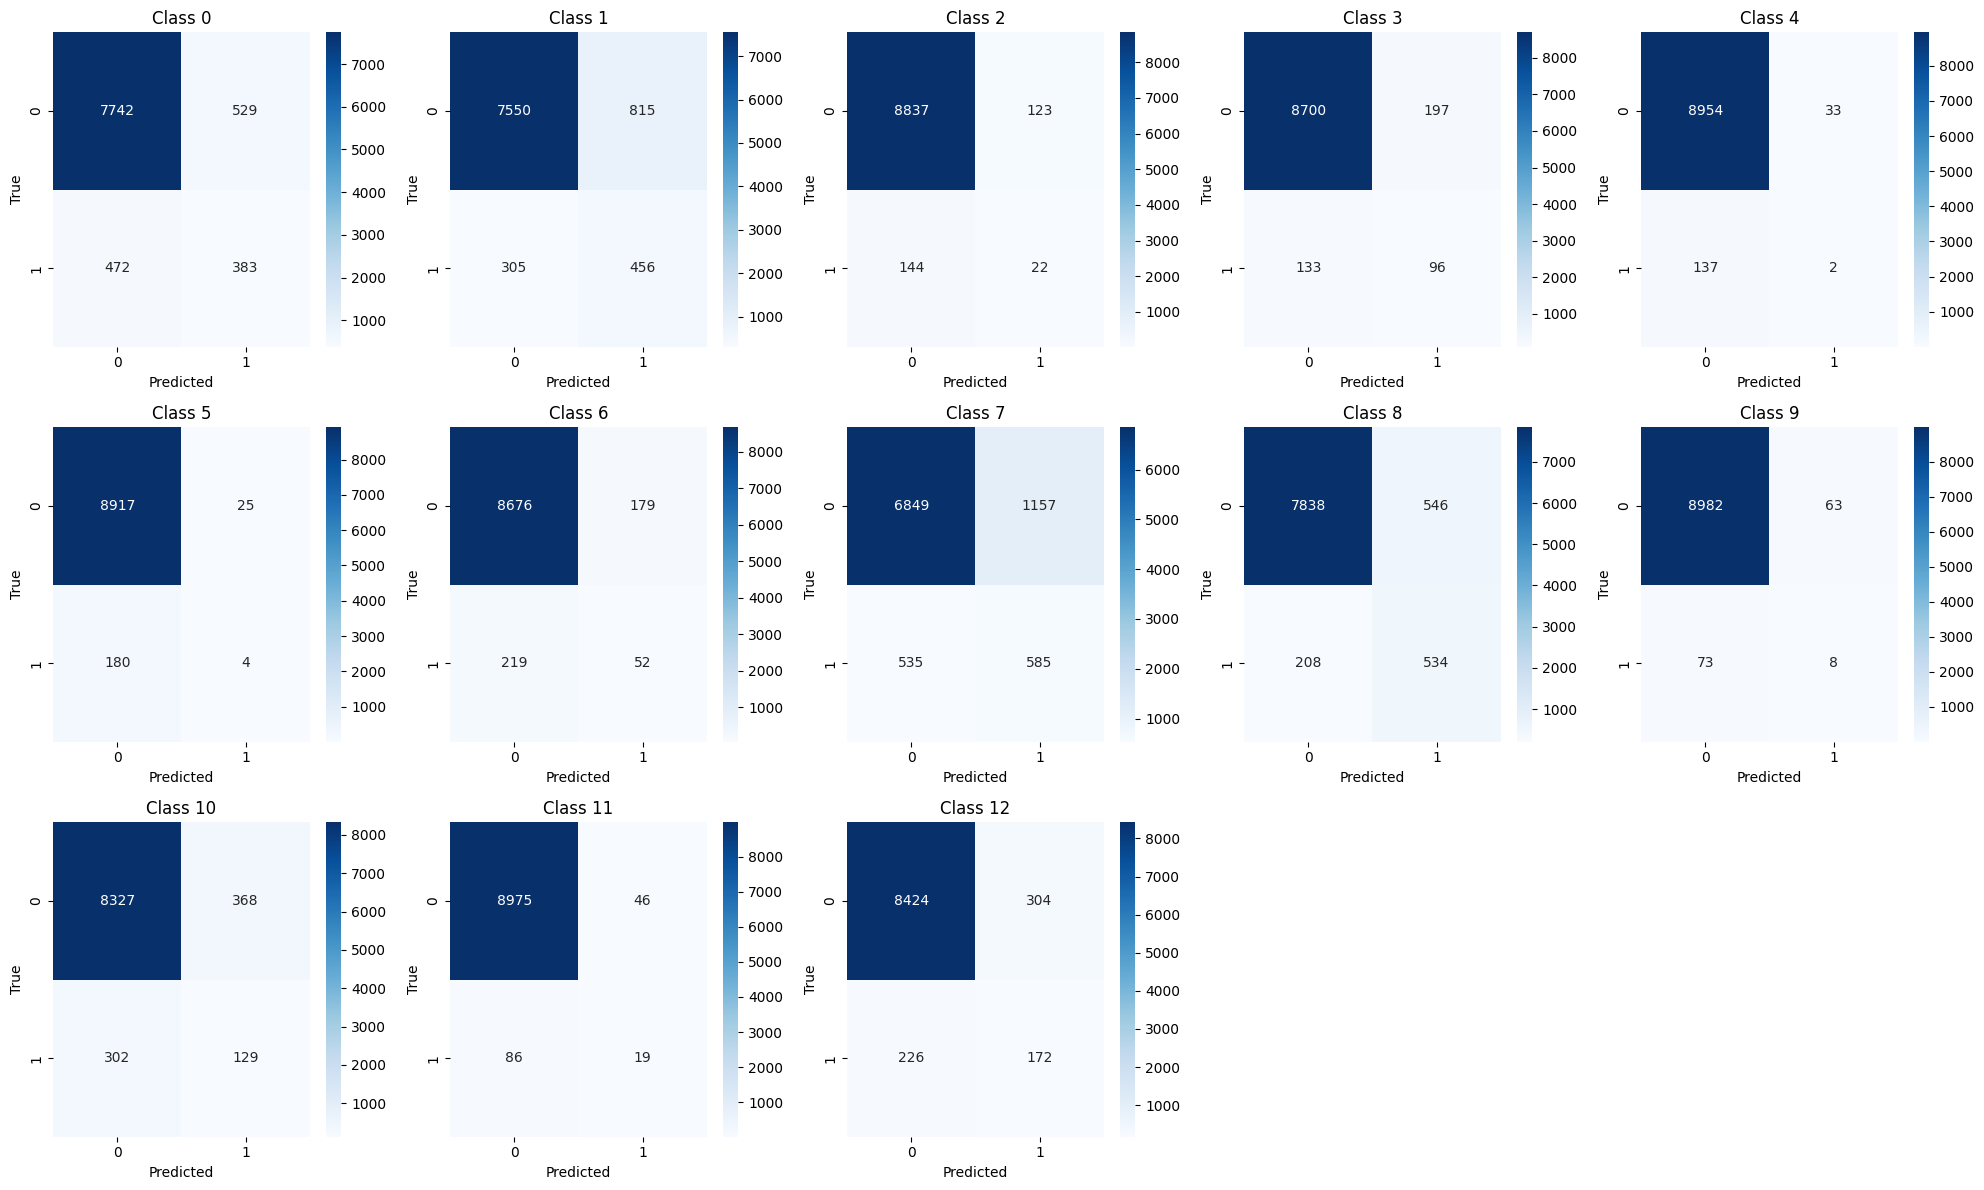

In [8]:
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, device, threshold=0.4):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['lab'].to(device)
            
            outputs = model(embeddings)  # (batch_size, num_classes)
            outputs = torch.sigmoid(outputs)  # 加上sigmoid
            preds = (outputs > threshold).float()  # 阈值默认0.5，可以调
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # 计算 F1 分数
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"\nF1 Score (macro): {f1:.4f}")
    
    # 打印分类报告
    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds, 
        target_names=[f"Class {i}" for i in range(all_labels.shape[1])]
    ))
    
    # 计算多标签混淆矩阵
    mcm = multilabel_confusion_matrix(all_labels, all_preds)

    # 绘制每一类的混淆矩阵
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, matrix in enumerate(mcm):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'Class {idx}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
    
    # 如果类别数<子图数，多余的子图关掉
    for i in range(len(mcm), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
evaluate_model(model, test_loader, device, threshold=0.4)


F1 Score (macro): 0.2779

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.39      0.44      0.42      1211
     Class 1       0.32      0.59      0.41      1085
     Class 2       0.15      0.15      0.15       243
     Class 3       0.34      0.41      0.37       356
     Class 4       0.02      0.01      0.01       189
     Class 5       0.18      0.04      0.06       292
     Class 6       0.23      0.20      0.21       392
     Class 7       0.33      0.53      0.41      1612
     Class 8       0.50      0.69      0.58      1121
     Class 9       0.16      0.15      0.15       123
    Class 10       0.23      0.25      0.24       685
    Class 11       0.27      0.16      0.20       175
    Class 12       0.36      0.43      0.39       572

   micro avg       0.35      0.44      0.39      8056
   macro avg       0.27      0.31      0.28      8056
weighted avg       0.33      0.44      0.37      8056
 samples avg       0.10      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


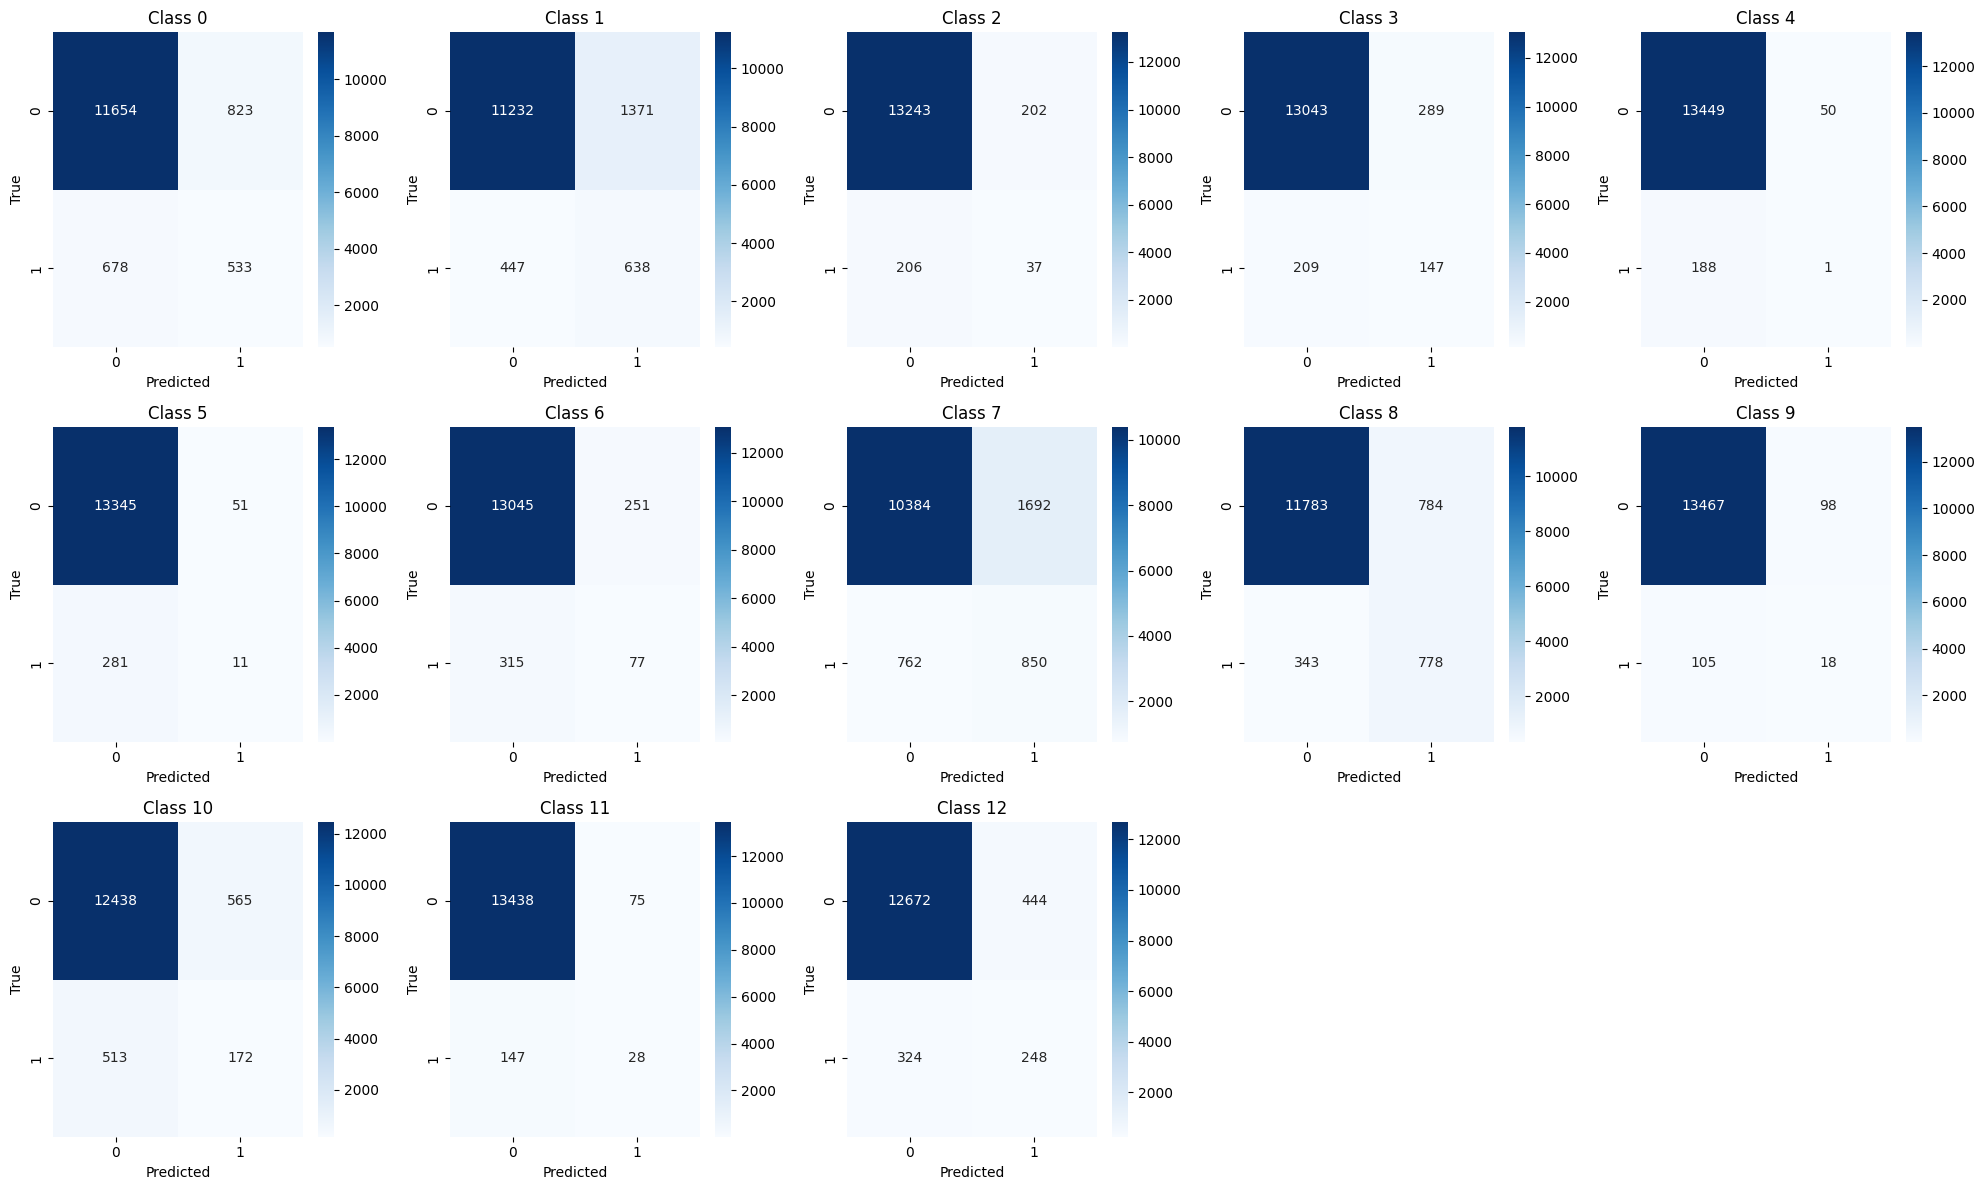

In [9]:
@torch.no_grad()
def evaluate_model(model, valid_loader, device, threshold=0.4):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in valid_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['lab'].to(device)
            
            outputs = model(embeddings)  # (batch_size, num_classes)
            outputs = torch.sigmoid(outputs)  # 加上sigmoid
            preds = (outputs > threshold).float()  # 阈值默认0.5，可以调
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # 计算 F1 分数
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"\nF1 Score (macro): {f1:.4f}")
    
    # 打印分类报告
    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds, 
        target_names=[f"Class {i}" for i in range(all_labels.shape[1])]
    ))
    
    # 计算多标签混淆矩阵
    mcm = multilabel_confusion_matrix(all_labels, all_preds)

    # 绘制每一类的混淆矩阵
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, matrix in enumerate(mcm):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'Class {idx}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
    
    # 如果类别数<子图数，多余的子图关掉
    for i in range(len(mcm), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
evaluate_model(model, valid_loader, device, threshold=0.4)